In [1]:
import numpy as np
import loompy
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import matplotlib.pyplot as plt
import glob
import bbknn
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
from pandas.core.index import RangeIndex

import scvelo as scv
scv.logging.print_version()

C:\Users\ryand\miniconda3\envs\scrna\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  


Running scvelo 0.2.1 (python 3.7.6) on 2020-10-17 12:26.
 Your version: 		 0.2.1 
 Latest version: 	 0.2.2


In [2]:
sc.settings.set_figure_params(dpi=140)

In [3]:
adata1 = sc.read_loom(
    r'D:\Paper Writing Driskell Lab\ExpDerm2020\NewLoomFiles\LWC_neg.loom',
    sparse=True, cleanup=False, X_name='spliced',
obs_names='CellID',
var_names='Gene', dtype='float32')   

adata2 = sc.read_loom(
    r'D:\Paper Writing Driskell Lab\ExpDerm2020\NewLoomFiles\LWC_pos.loom',
    sparse=True, cleanup=False, X_name='spliced',
obs_names='CellID',
var_names='Gene', dtype='float32')   

adata3 = sc.read_loom(
    r'D:\Paper Writing Driskell Lab\ExpDerm2020\NewLoomFiles\LWP_neg.loom',
    sparse=True, cleanup=False, X_name='spliced',
obs_names='CellID',
var_names='Gene', dtype='float32')   

adata4 = sc.read_loom(
    r'D:\Paper Writing Driskell Lab\ExpDerm2020\NewLoomFiles\LWP_pos.loom',
    sparse=True, cleanup=False, X_name='spliced',
obs_names='CellID',
var_names='Gene', dtype='float32')   

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata1.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

adata2.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

adata3.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

adata4.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [5]:
adataLWC = adata1.concatenate(adata2, batch_key='batch', batch_categories=['LWCneg','LWCpos'])

adataLWP = adata3.concatenate(adata4, batch_key='batch', batch_categories=['LWPneg','LWPpos'])

adata = adataLWC.concatenate(adataLWP, batch_key='Time', batch_categories=['Center14dpw','Peripheral14dpw'])

In [6]:
adata

AnnData object with n_obs × n_vars = 24014 × 31045
    obs: 'batch', 'Time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

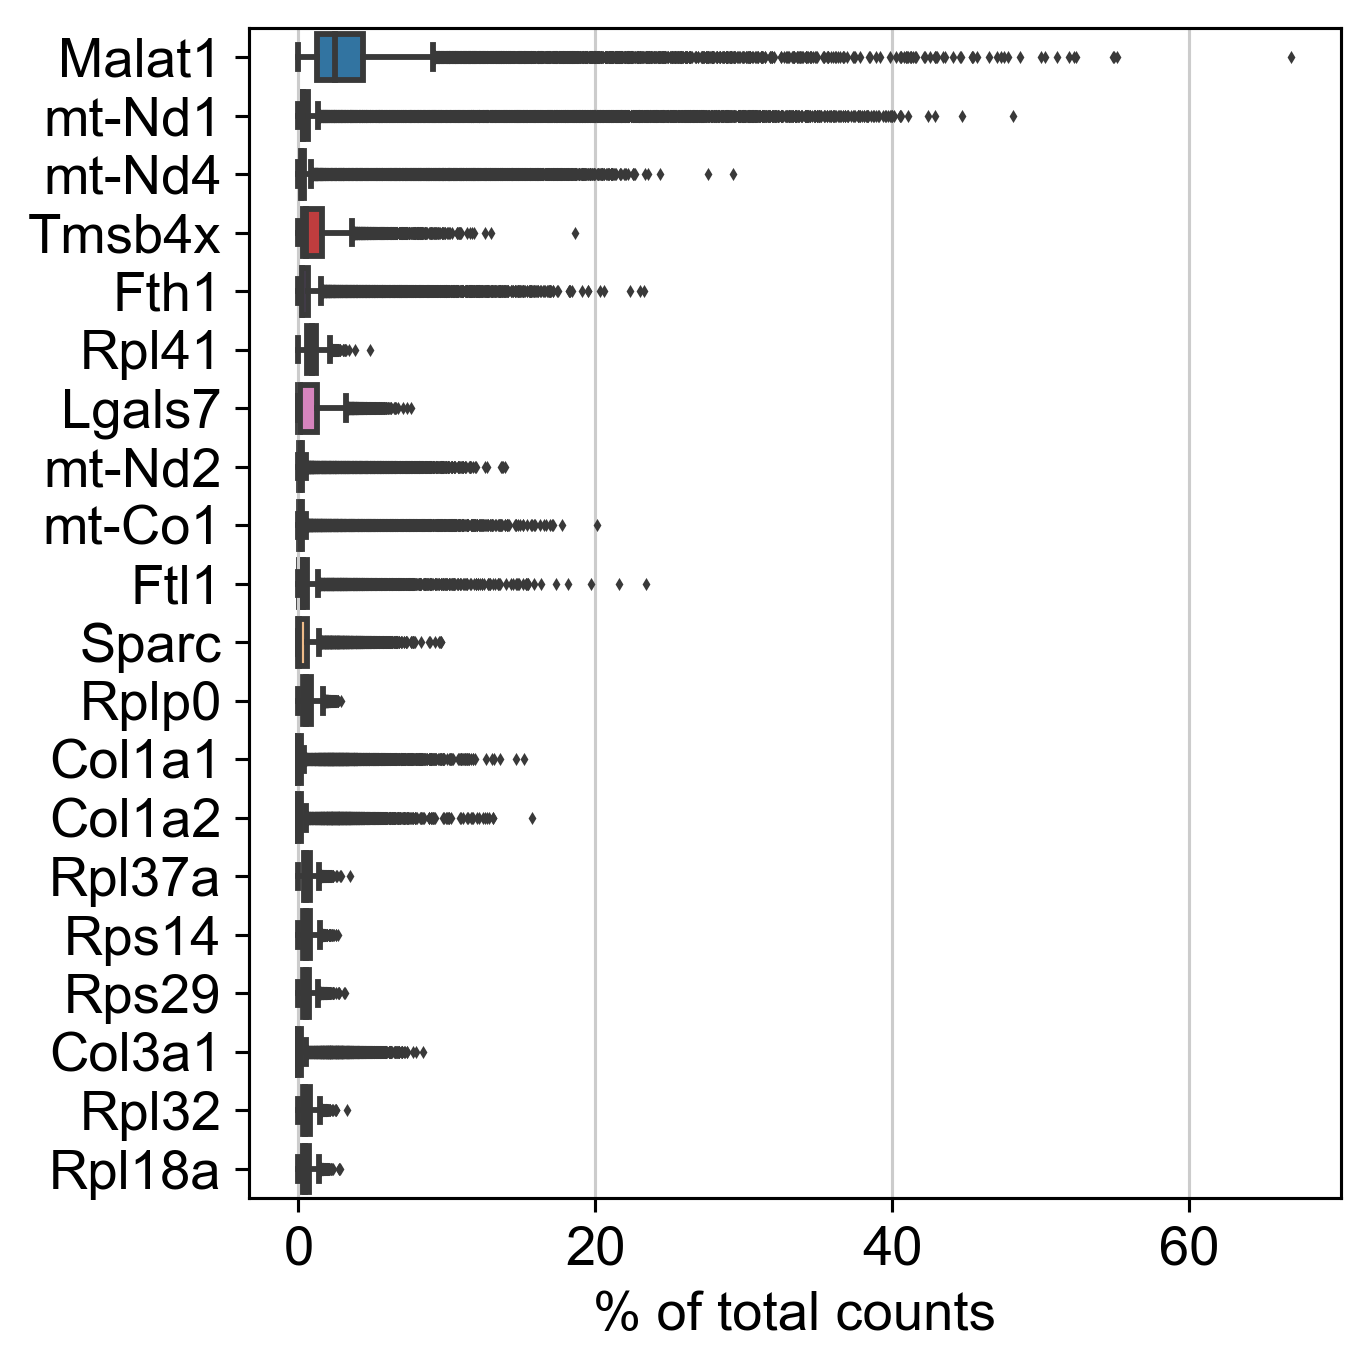

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'batch' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


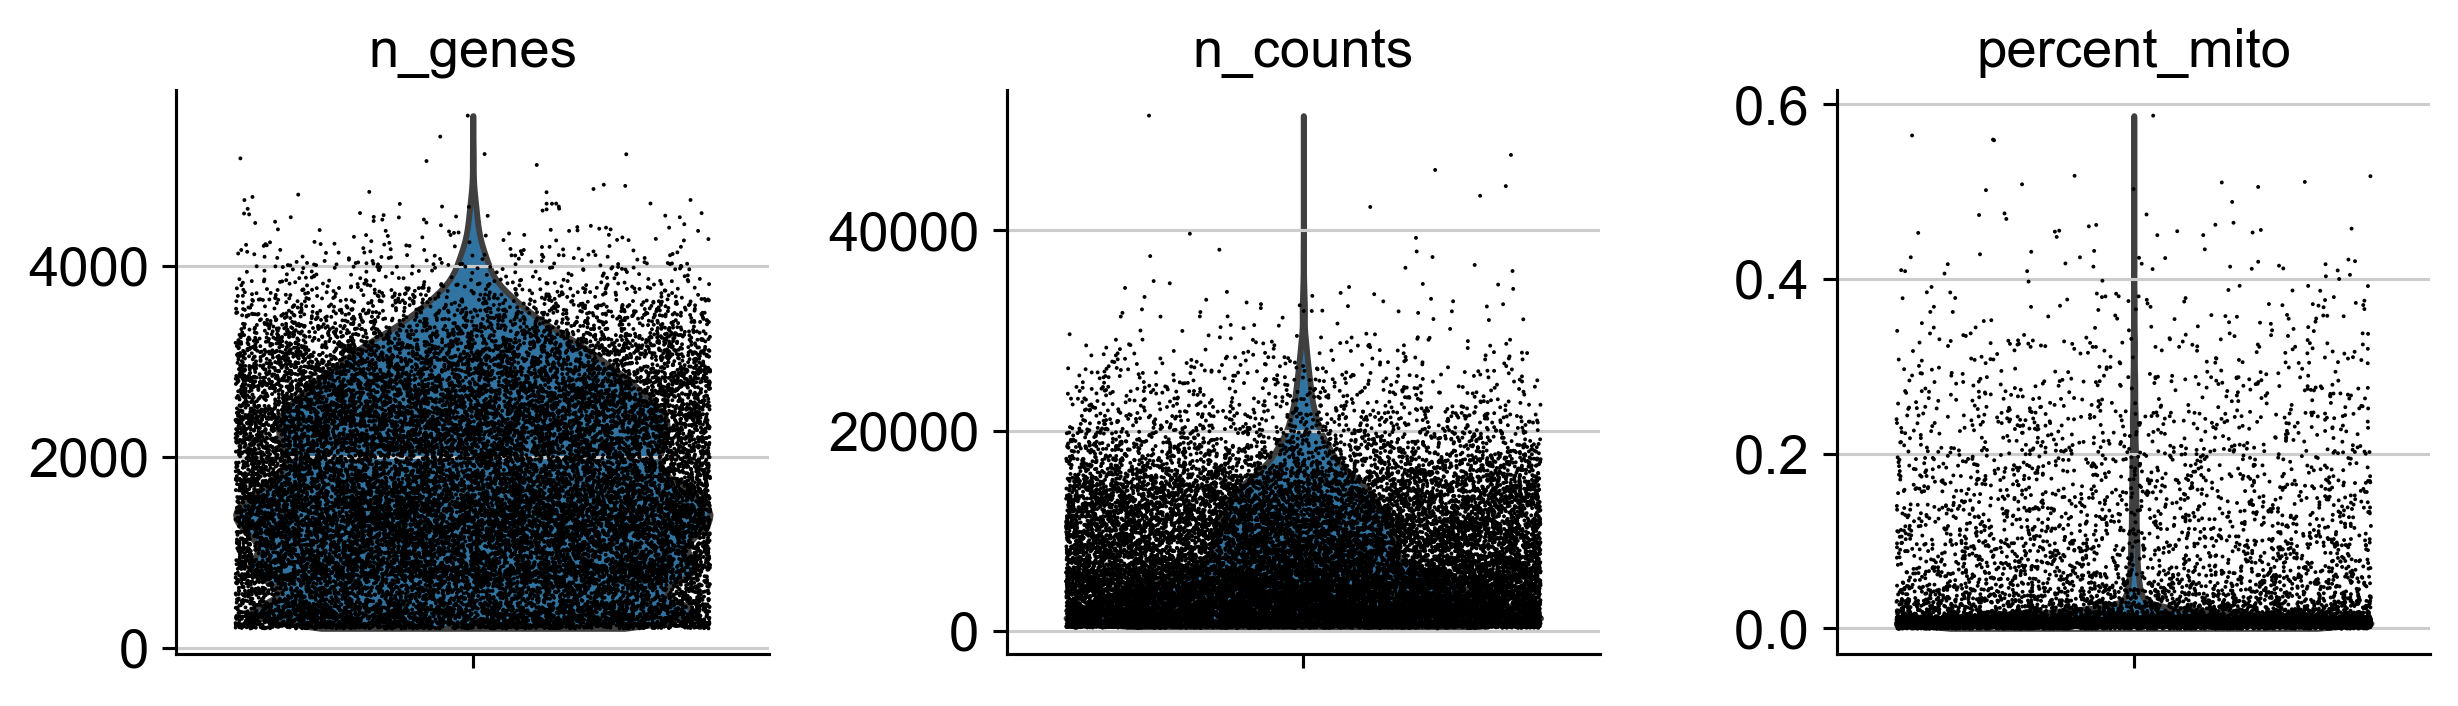

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'],
             jitter=0.4, multi_panel=True)

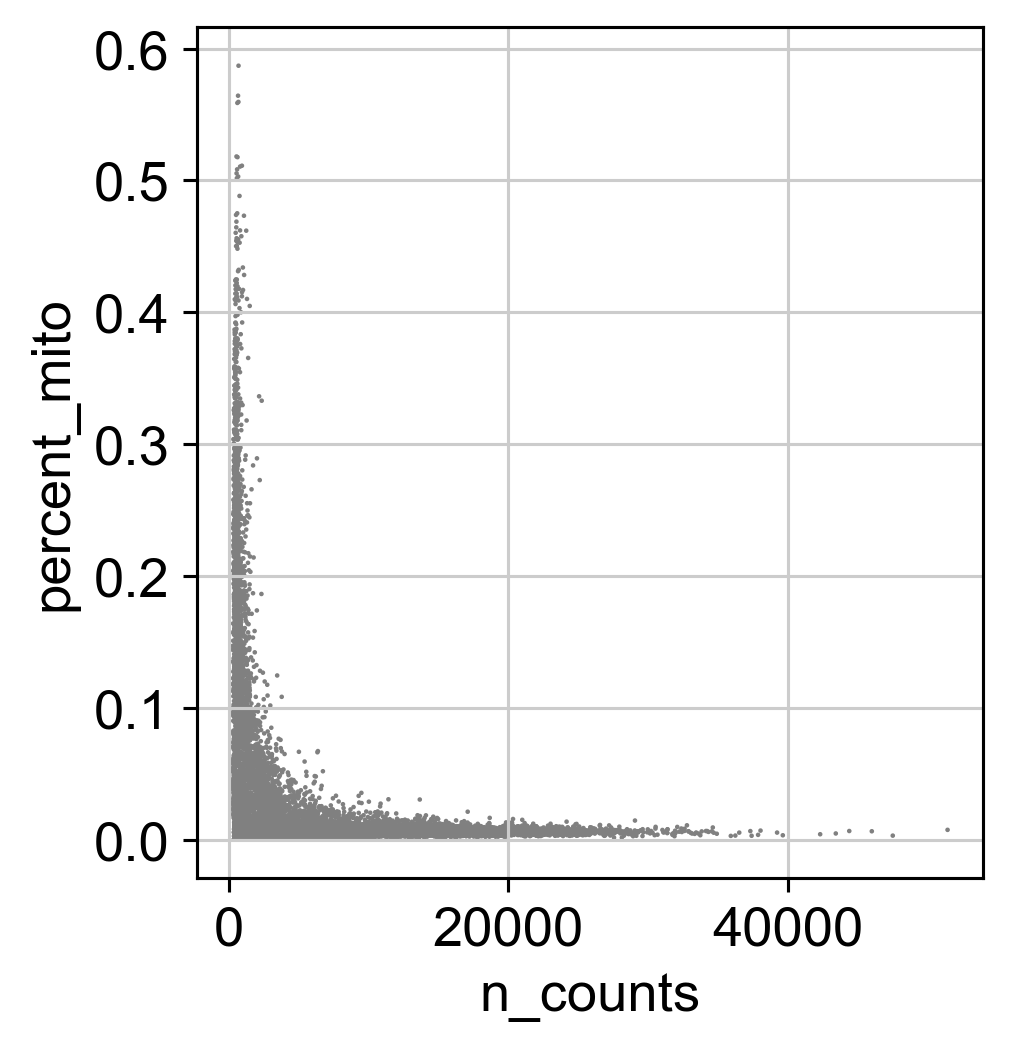

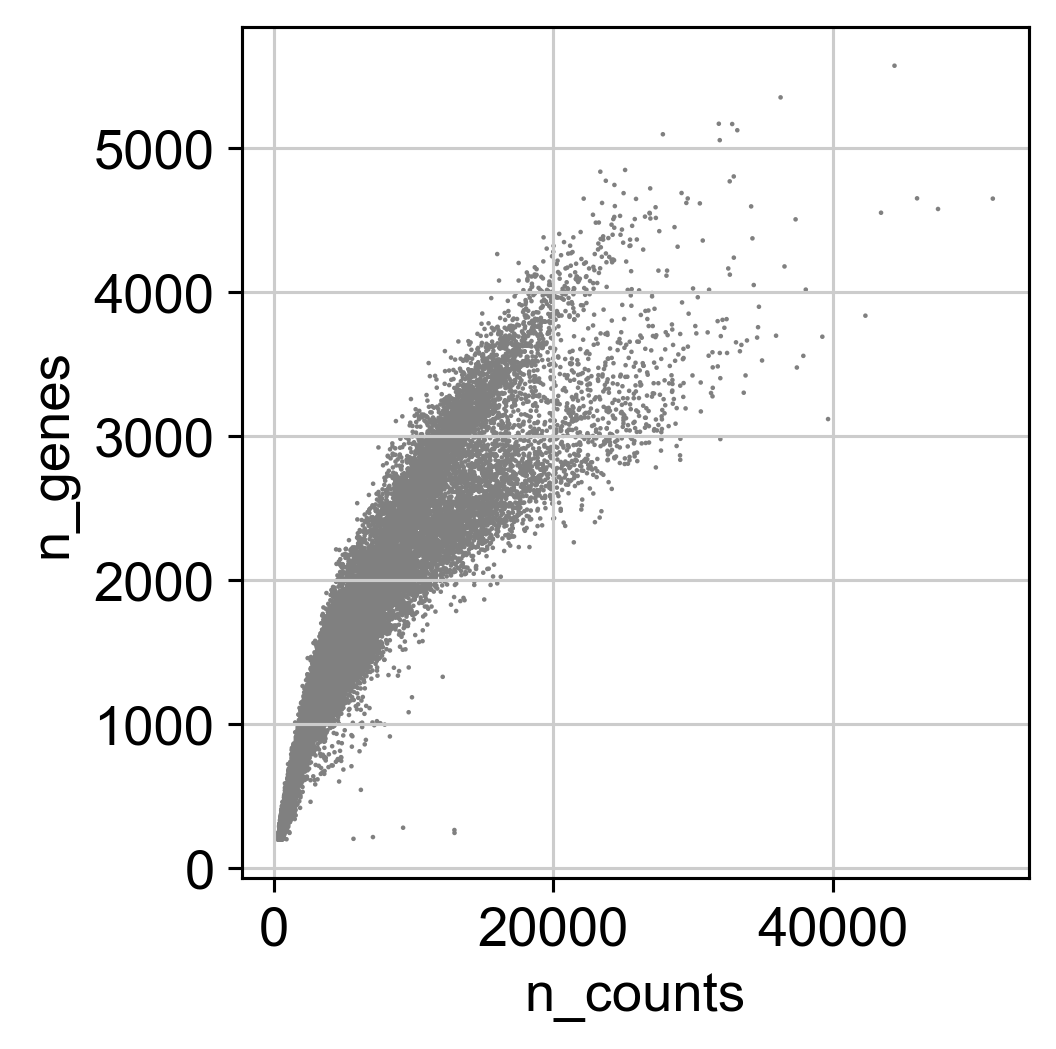

In [11]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata

AnnData object with n_obs × n_vars = 21553 × 19785
    obs: 'batch', 'Time', 'n_genes', 'percent_mito', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [13]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Trying to set attribute `.obs` of view, copying.


In [15]:
sc.pp.log1p(adata)

In [16]:
adata.raw = adata

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

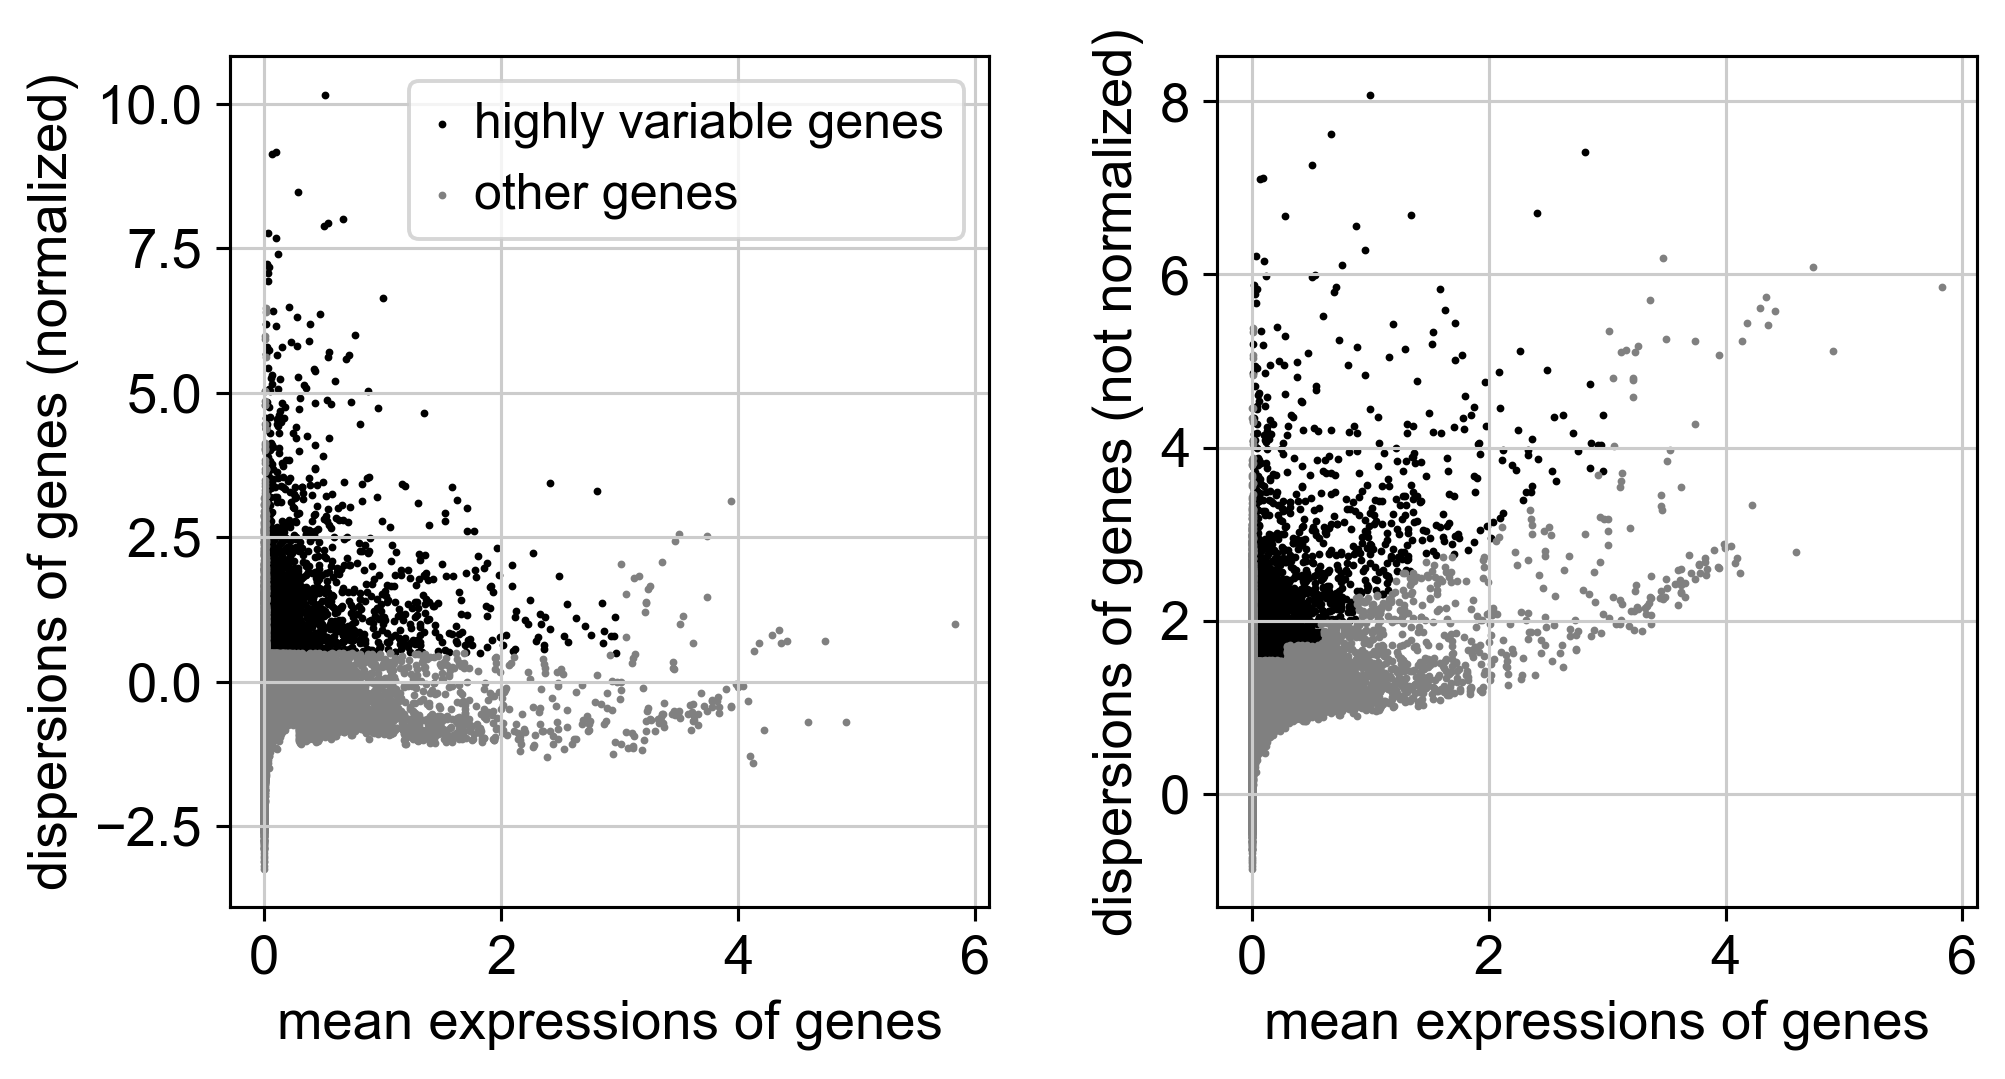

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
adata = adata[:, adata.var['highly_variable']]

In [20]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [21]:
sc.pp.scale(adata, max_value=10)

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

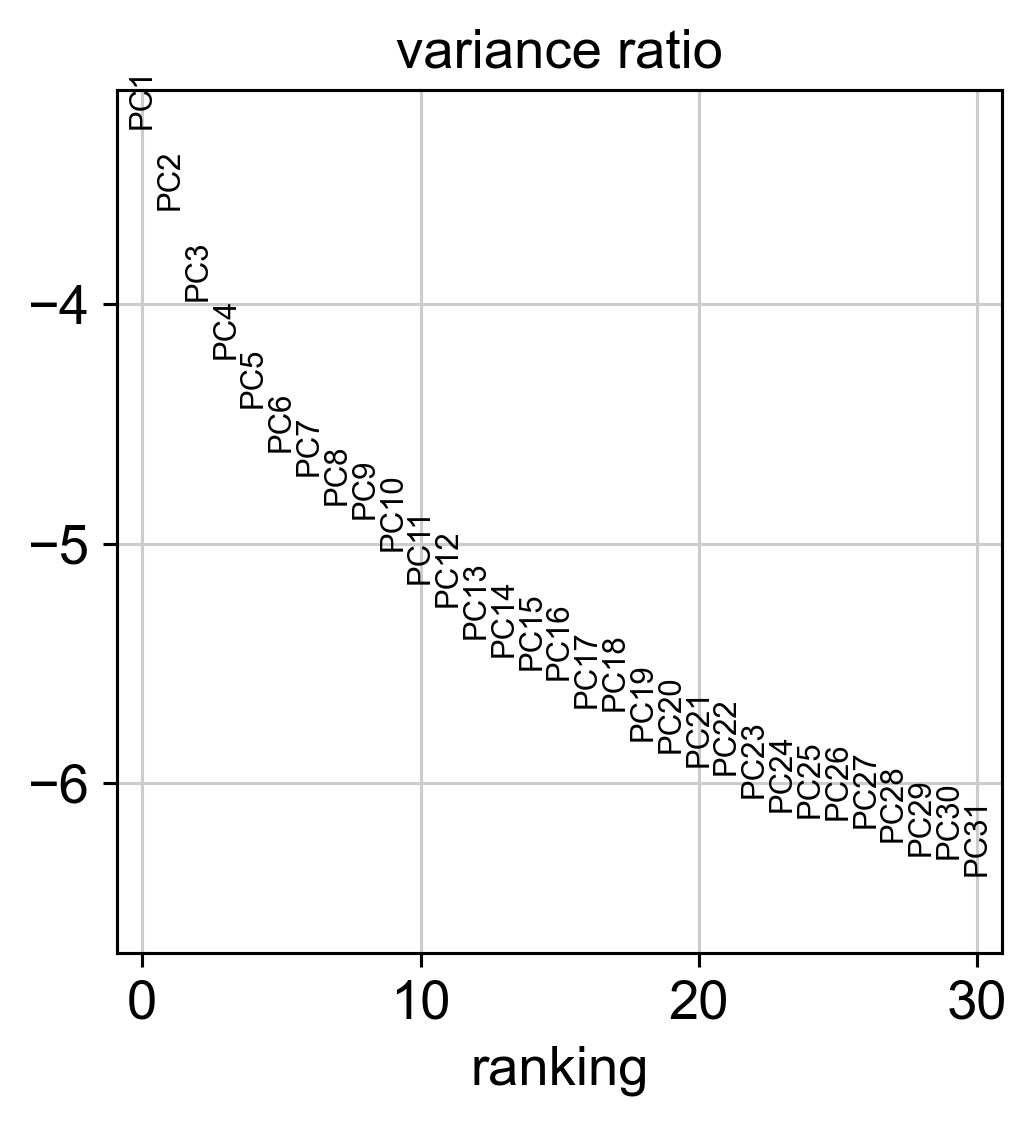

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
adata

AnnData object with n_obs × n_vars = 19344 × 2806
    obs: 'batch', 'Time', 'n_genes', 'percent_mito', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [27]:
sc.tl.umap(adata)

In [28]:
marker_genes = ['Krt14', 'Krt15','Krt17','Krt79','Tyrobp','Lyz2','Ptprc','Dct',
                'Vim','Pdgfra','Twist2','En1','Inhba','Plp1','Mbp','Rgs5','Acta2','Pecam1','Dpt','Corin','Hey1',
                'Sox18','Rspo3','Cd200'
                 ]

In [30]:
sc.tl.leiden(adata, resolution=0.1)

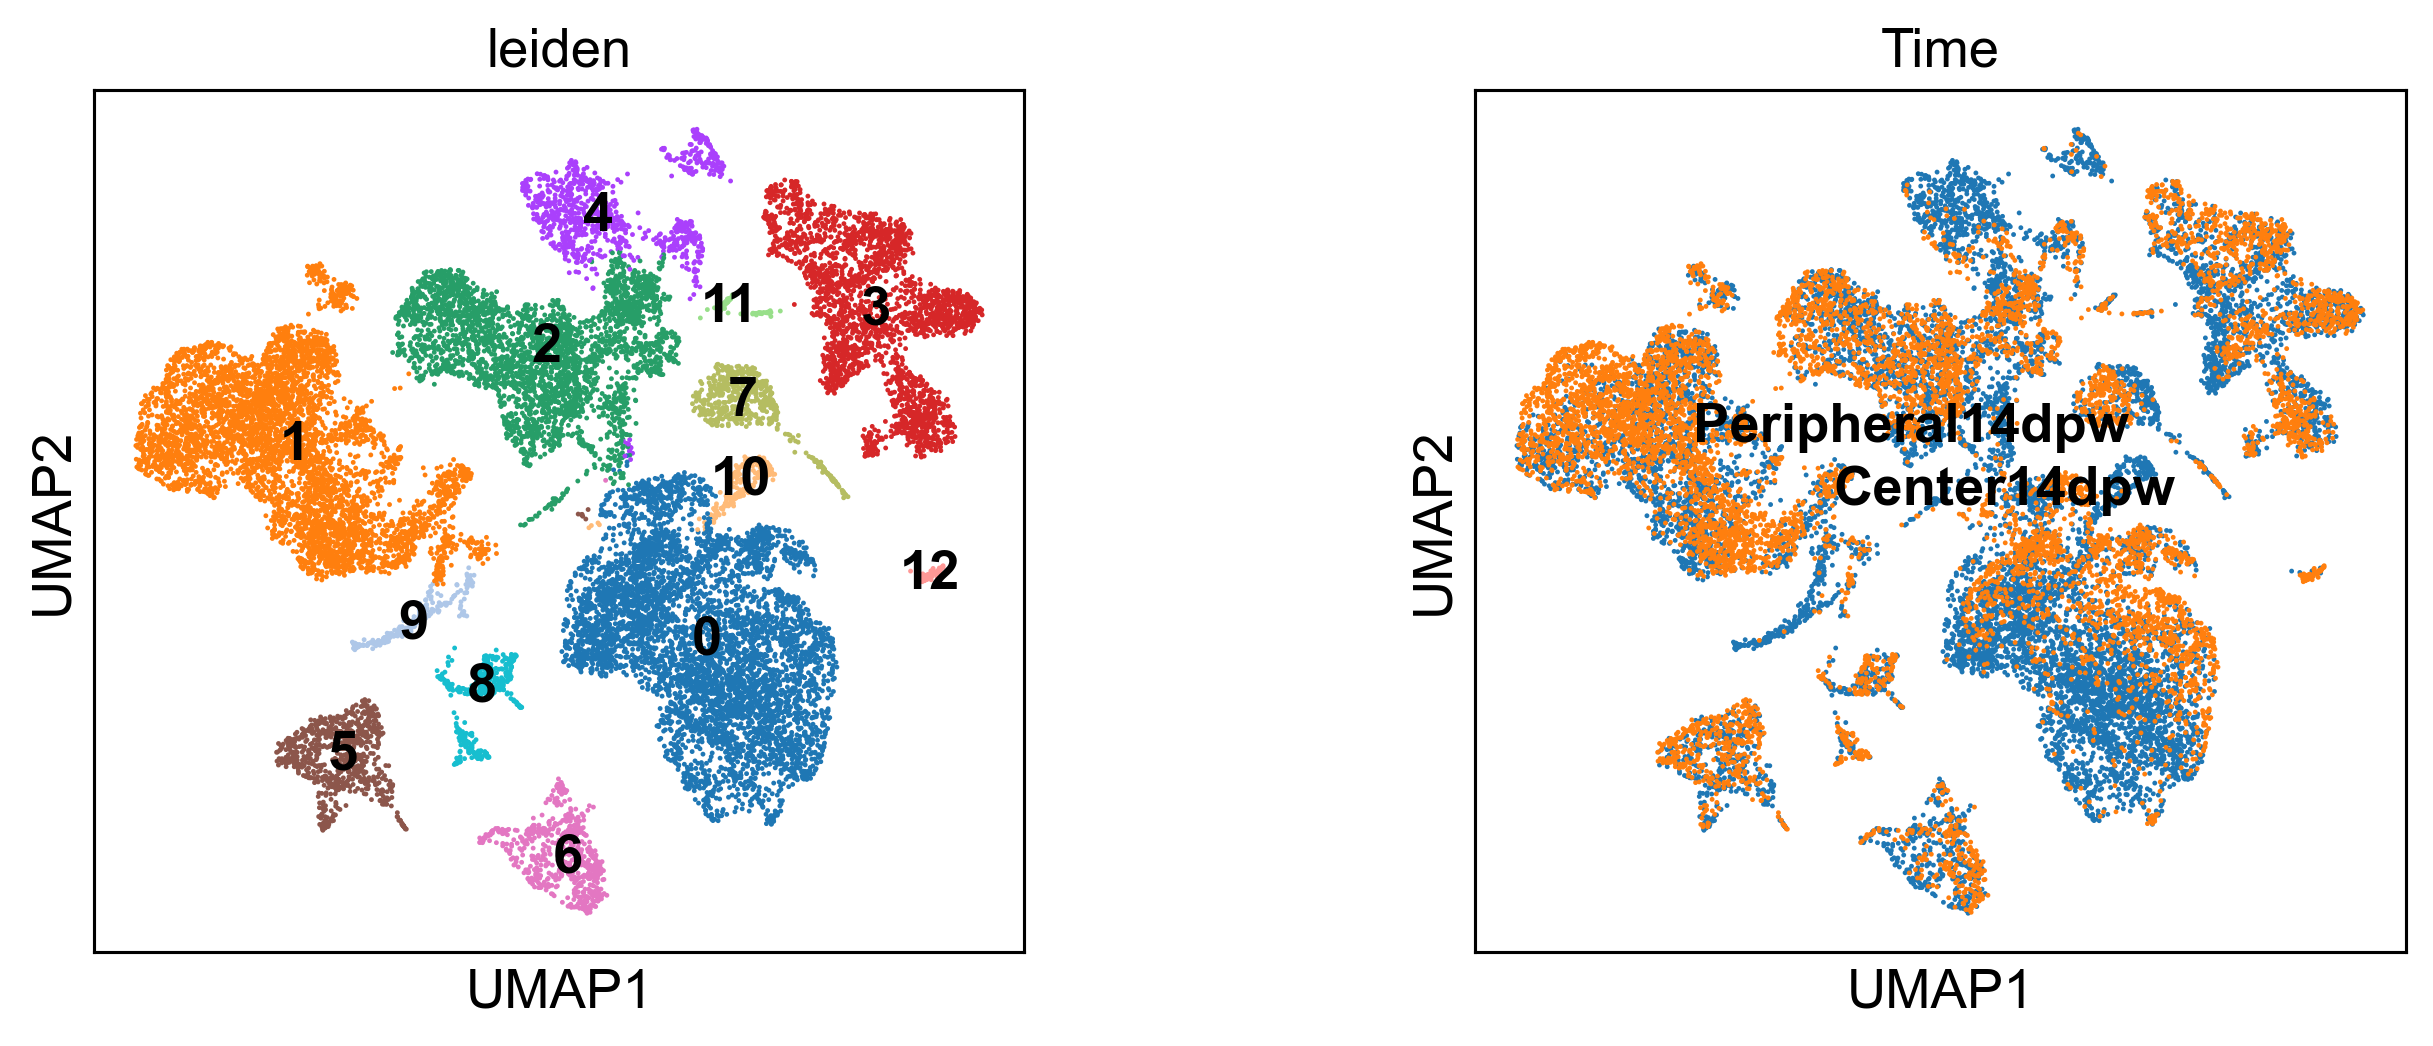

In [31]:
sc.pl.umap(adata, color=['leiden','Time'], legend_loc='on data', wspace=0.35)

In [32]:
#####SUBSETTING THE DATA#####

In [33]:
adata_subset1 = adata[adata.obs['leiden'].isin(
    ['1','9'])]

In [34]:
adata_subset1

View of AnnData object with n_obs × n_vars = 5028 × 2806
    obs: 'batch', 'Time', 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Time_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [35]:
sc.tl.pca(adata_subset1, svd_solver='arpack')

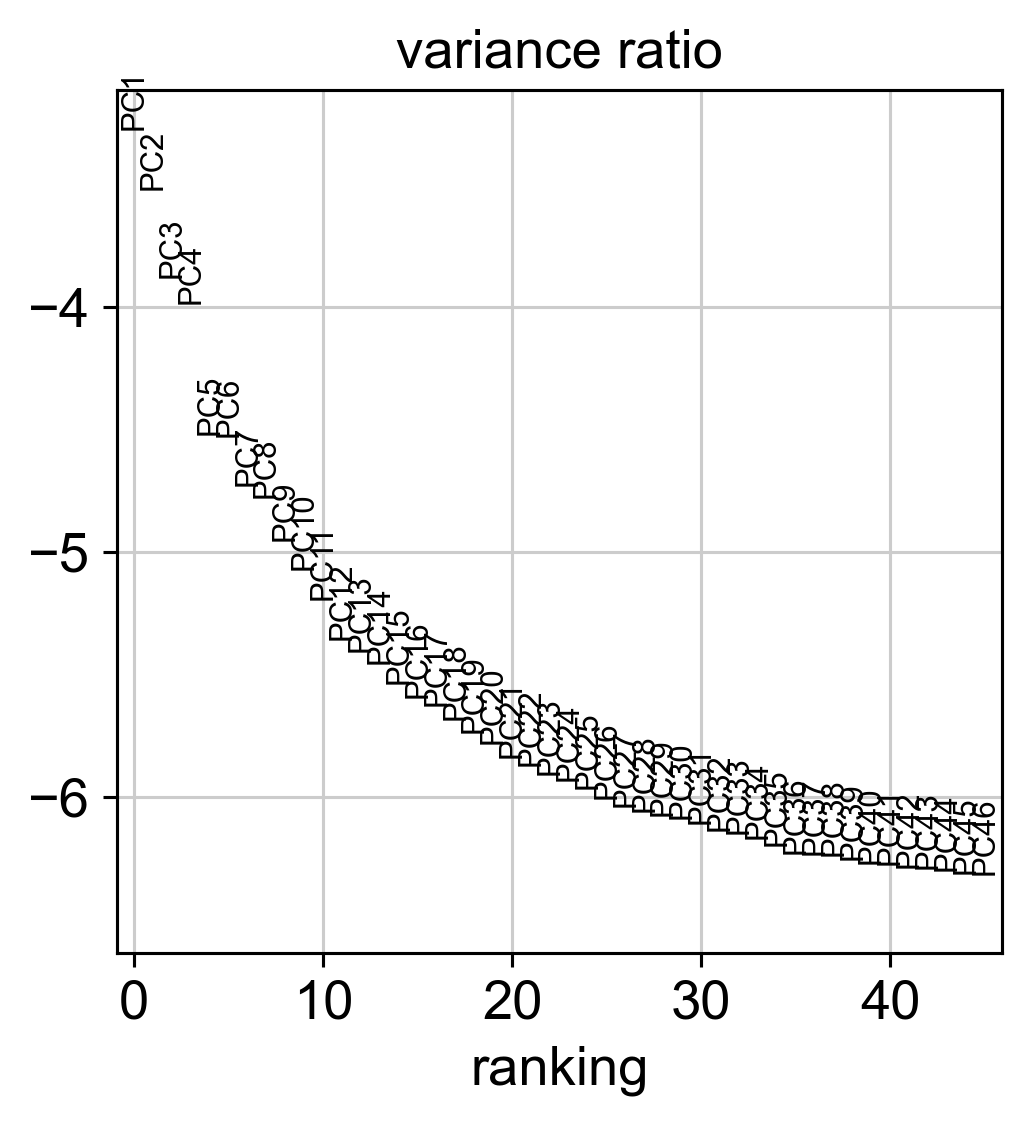

In [36]:
sc.pl.pca_variance_ratio(adata_subset1, n_pcs=45, log=True)

In [37]:
sc.pp.neighbors(adata_subset1)

In [38]:
sc.tl.umap(adata_subset1)

In [39]:
sc.tl.leiden(adata_subset1, resolution=1)

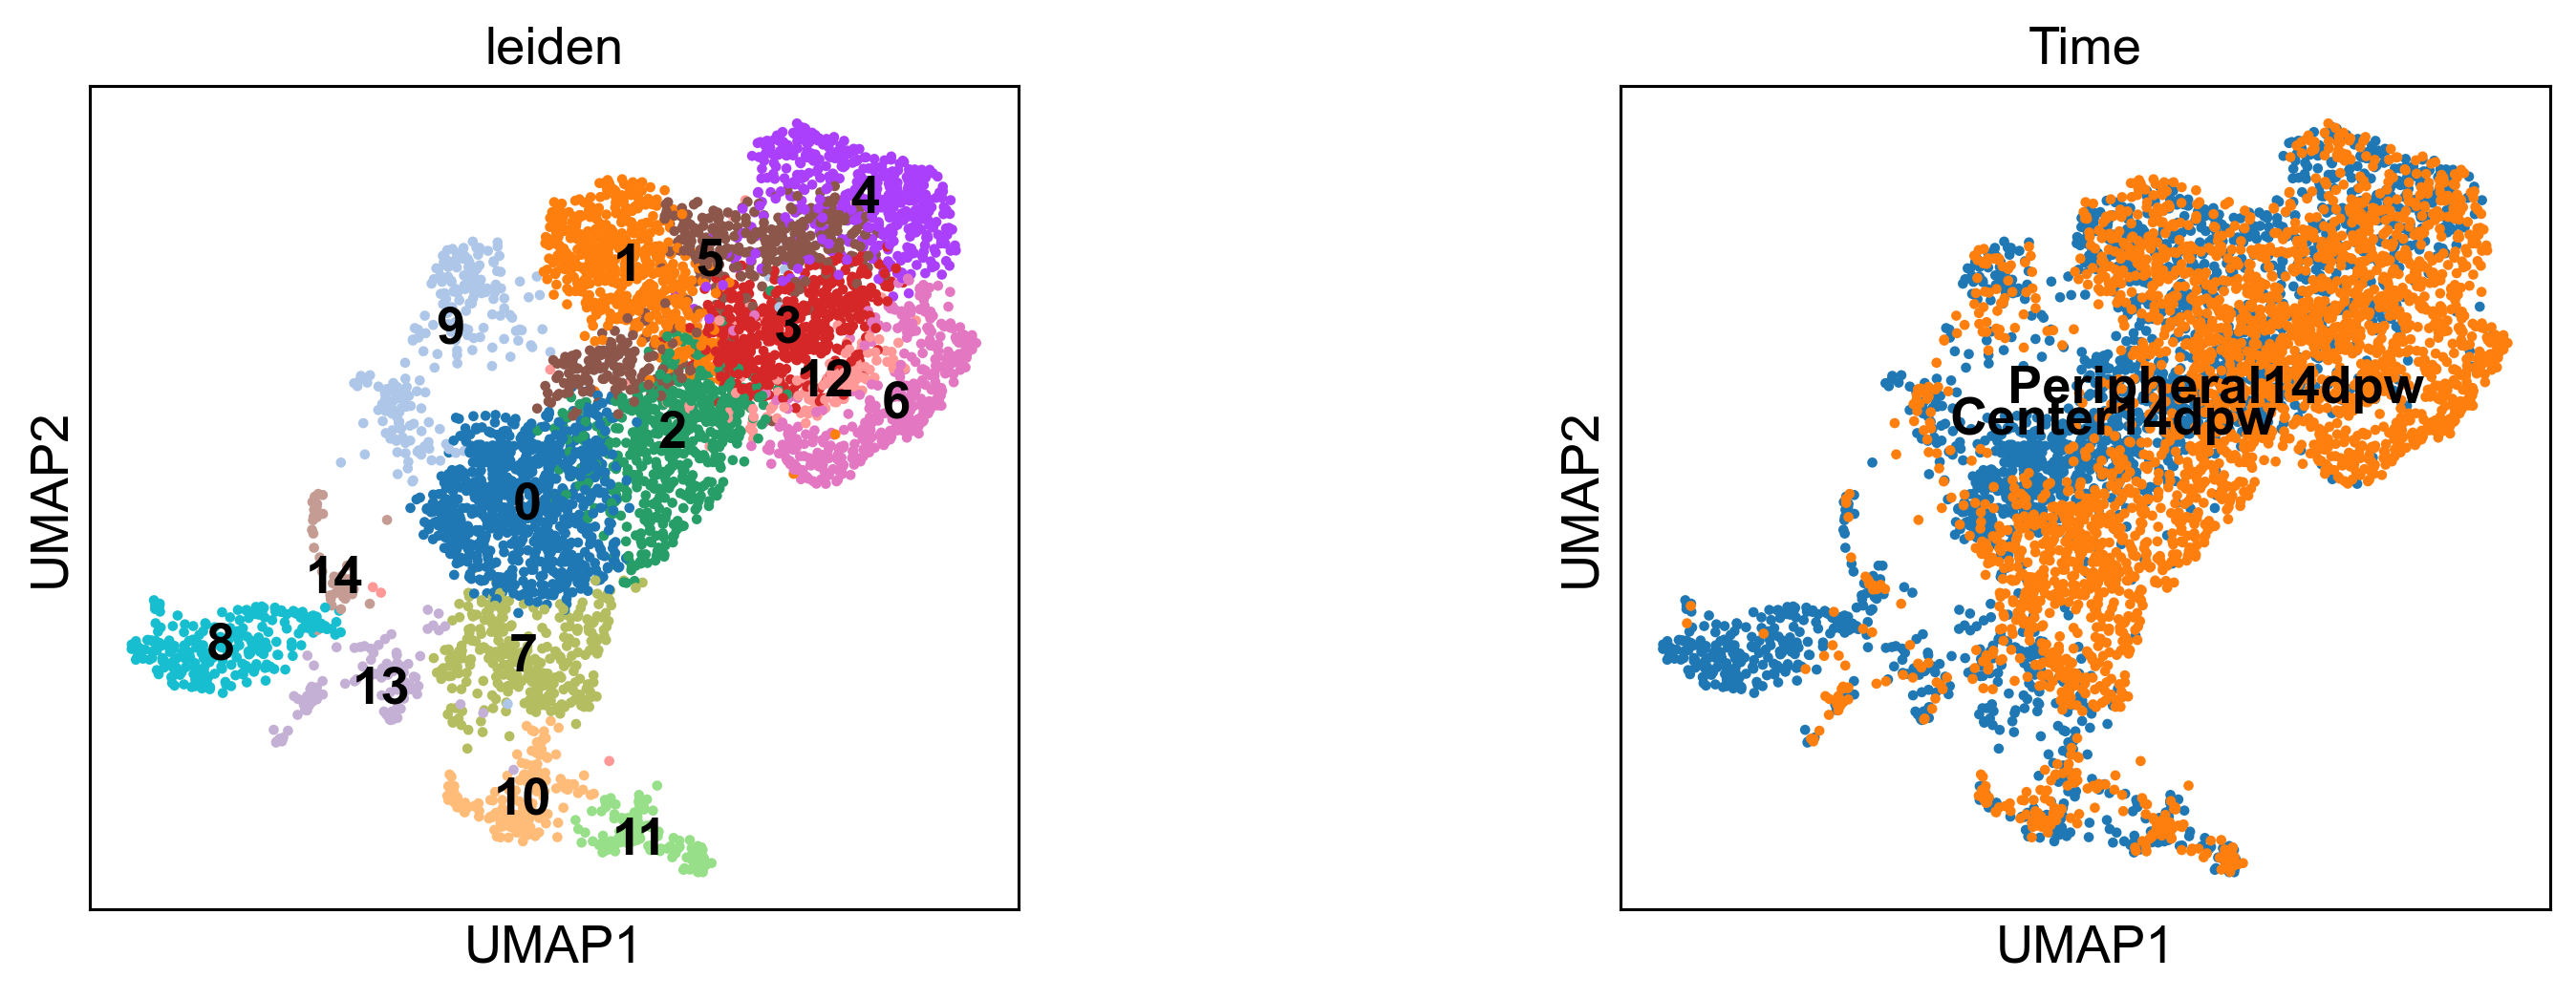

In [40]:
sc.pl.umap(adata_subset1, color=['leiden','Time'], legend_loc='on data', wspace=0.5, size=30)

In [41]:
#####SUBSETTING THE DATA#####

In [42]:
adata_subset = adata_subset1[adata_subset1.obs['leiden'].isin(
    ['0','1','2','3','4','5','6','7','8','10','11','12','13','14'])]

In [43]:
adata_subset

View of AnnData object with n_obs × n_vars = 4798 × 2806
    obs: 'batch', 'Time', 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Time_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [44]:
sc.tl.pca(adata_subset, svd_solver='arpack')

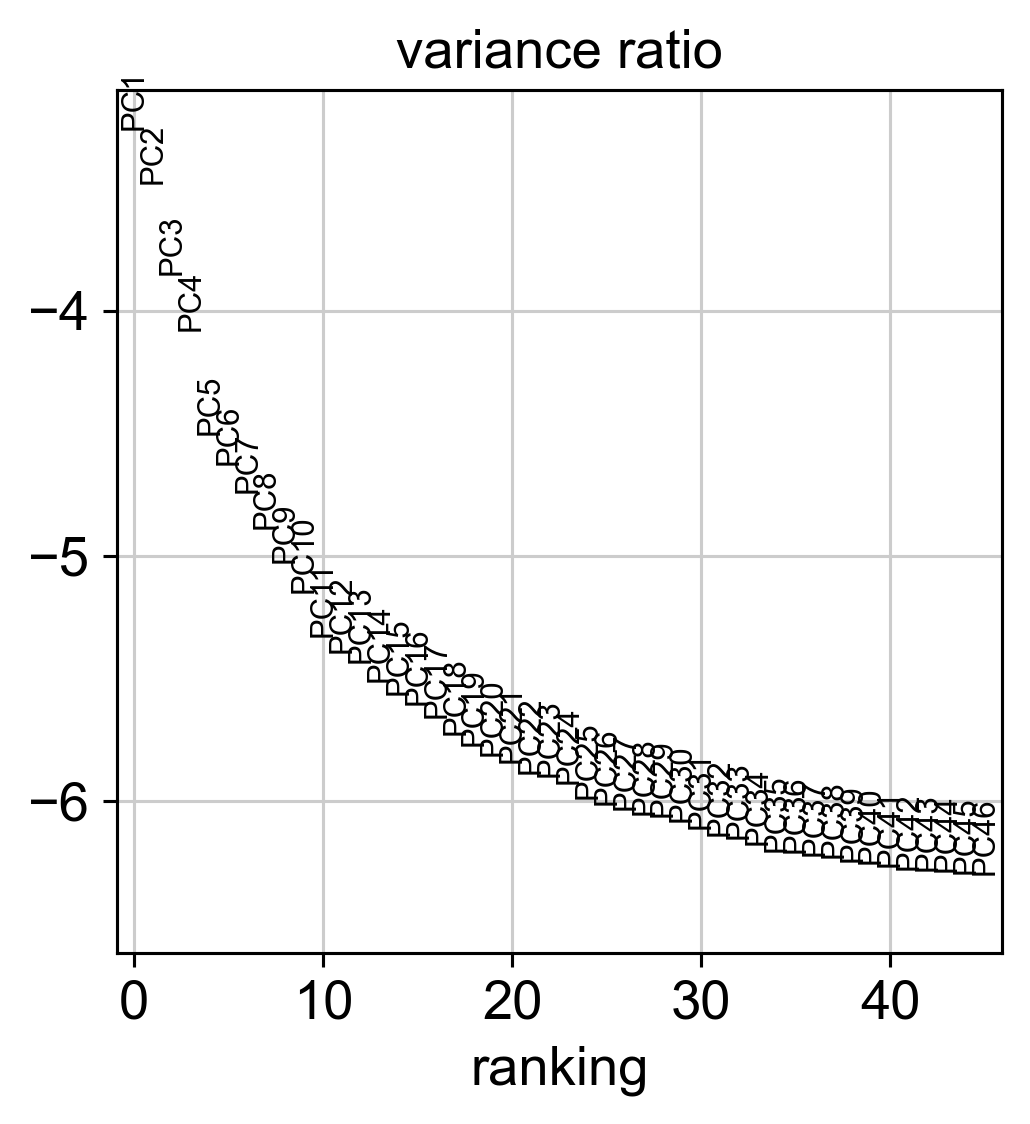

In [46]:
sc.pl.pca_variance_ratio(adata_subset, n_pcs=45, log=True)

In [47]:
#bdata = bbknn.bbknn(adata_subset,batch_key='Time',copy=True)

In [48]:
#sc.tl.umap(adata_subset)

In [49]:
sc.pp.neighbors(adata_subset)

In [50]:
sc.tl.umap(adata_subset)

In [51]:
sc.tl.leiden(adata_subset)

In [56]:
sc.settings.set_figure_params(dpi=140)

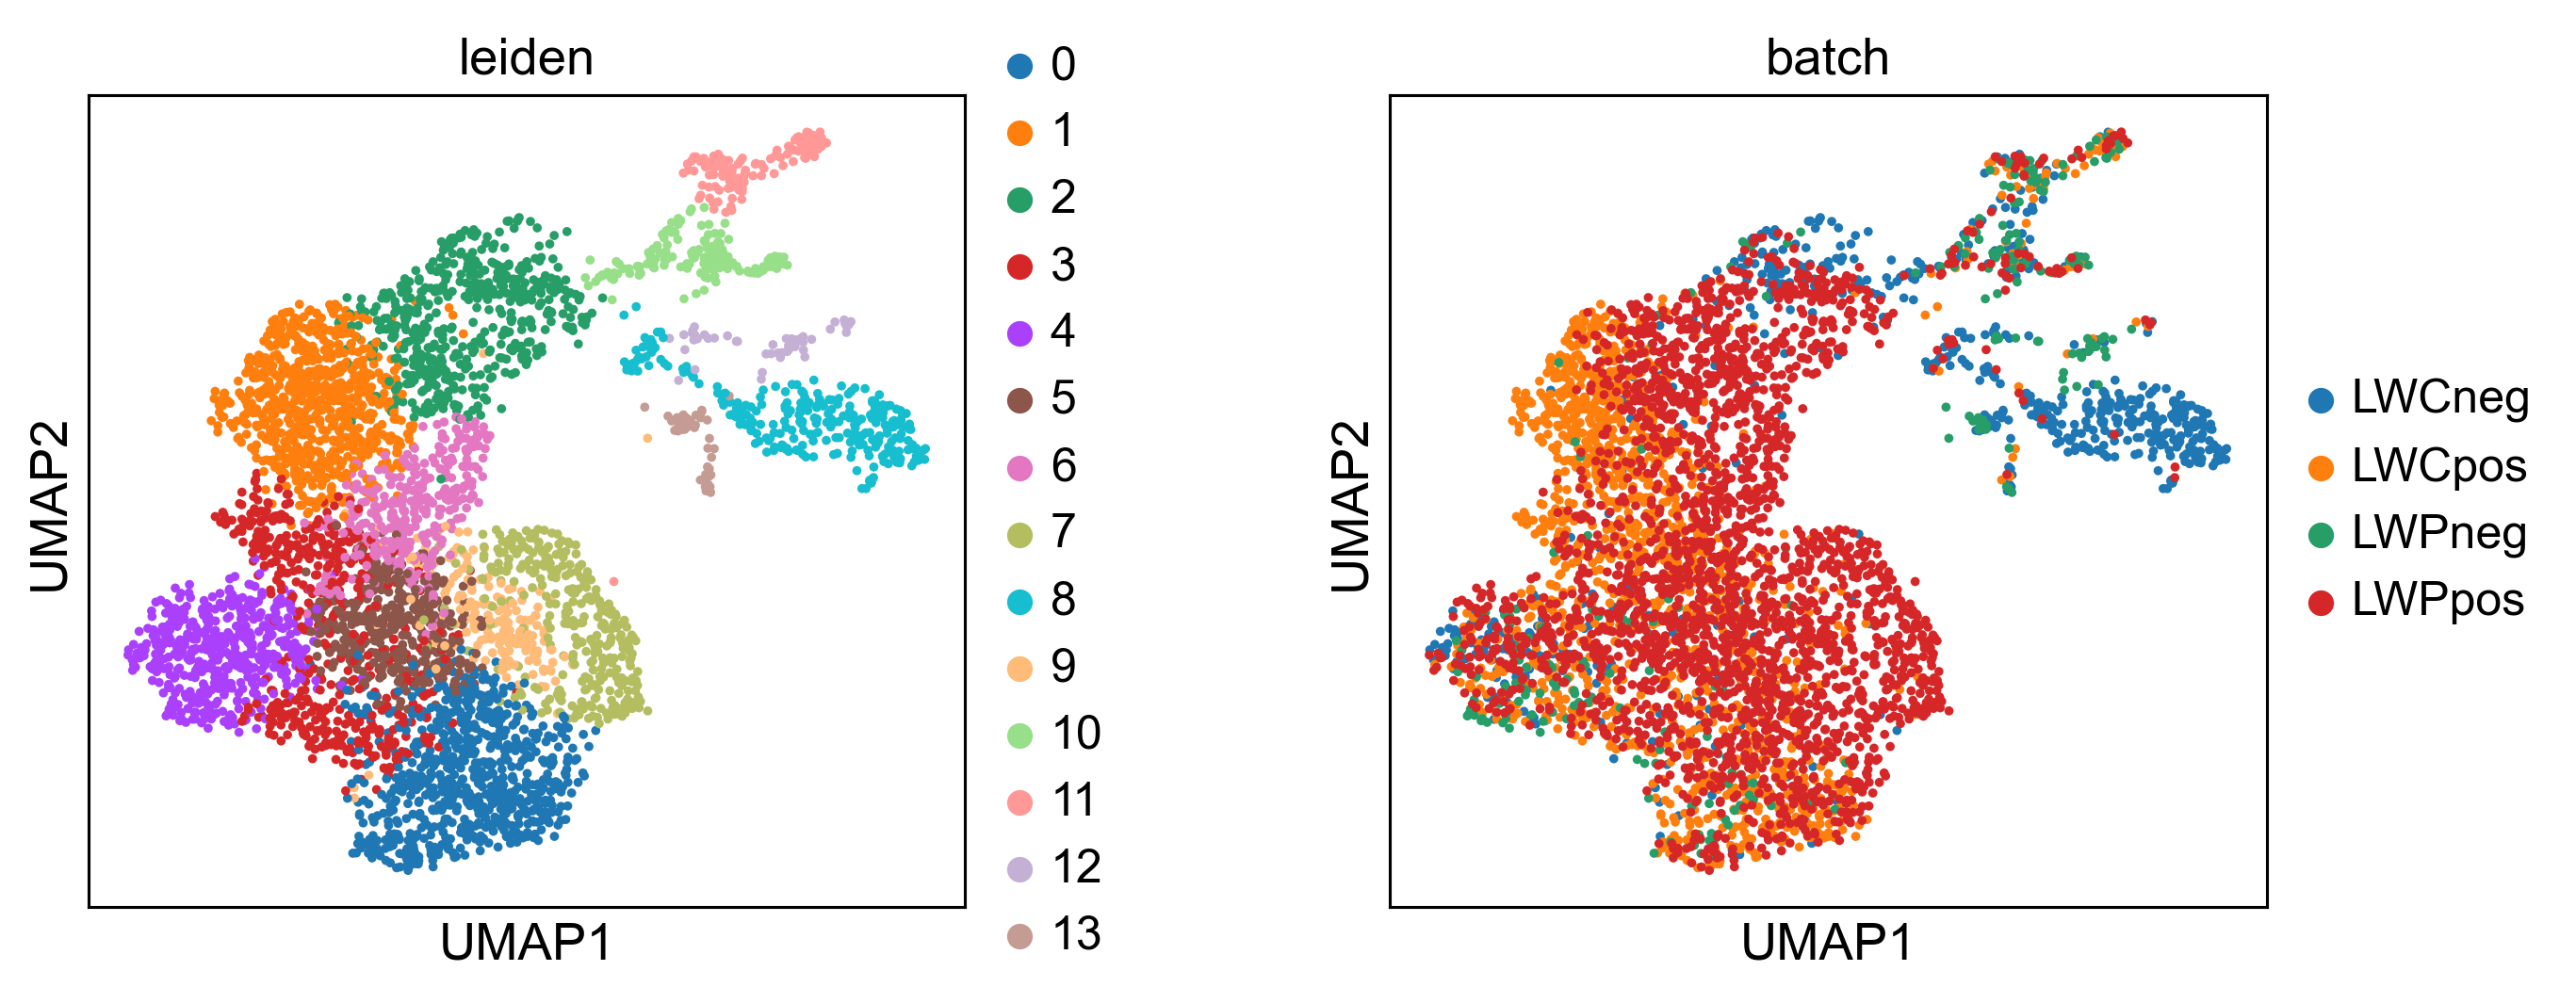

In [58]:
sc.pl.umap(adata_subset, color=['leiden','batch'], 
           color_map= 'viridis',
           wspace=0.35)

In [63]:
adata_subset.obs.groupby(["leiden",'batch']).apply(len)

leiden  batch 
0       LWCneg     24
        LWCpos    277
        LWPneg     34
        LWPpos    384
1       LWCneg     17
        LWCpos    445
        LWPneg      7
        LWPpos    245
2       LWCneg     96
        LWCpos     19
        LWPneg      8
        LWPpos    374
3       LWCneg     12
        LWCpos    225
        LWPneg     19
        LWPpos    219
4       LWCneg     97
        LWCpos    137
        LWPneg     49
        LWPpos    187
5       LWCneg     16
        LWCpos    119
        LWPneg      6
        LWPpos    264
6       LWCneg      1
        LWCpos     65
        LWPpos    260
7       LWCneg      3
        LWCpos      9
        LWPpos    310
8       LWCneg    263
        LWCpos      4
        LWPneg      4
        LWPpos     13
9       LWCneg      4
        LWCpos     43
        LWPneg      3
        LWPpos    139
10      LWCneg     55
        LWCpos     19
        LWPneg     47
        LWPpos     35
11      LWCneg     29
        LWCpos     38
        LWPneg   

In [66]:
###COLORING THE TIME PLOT####

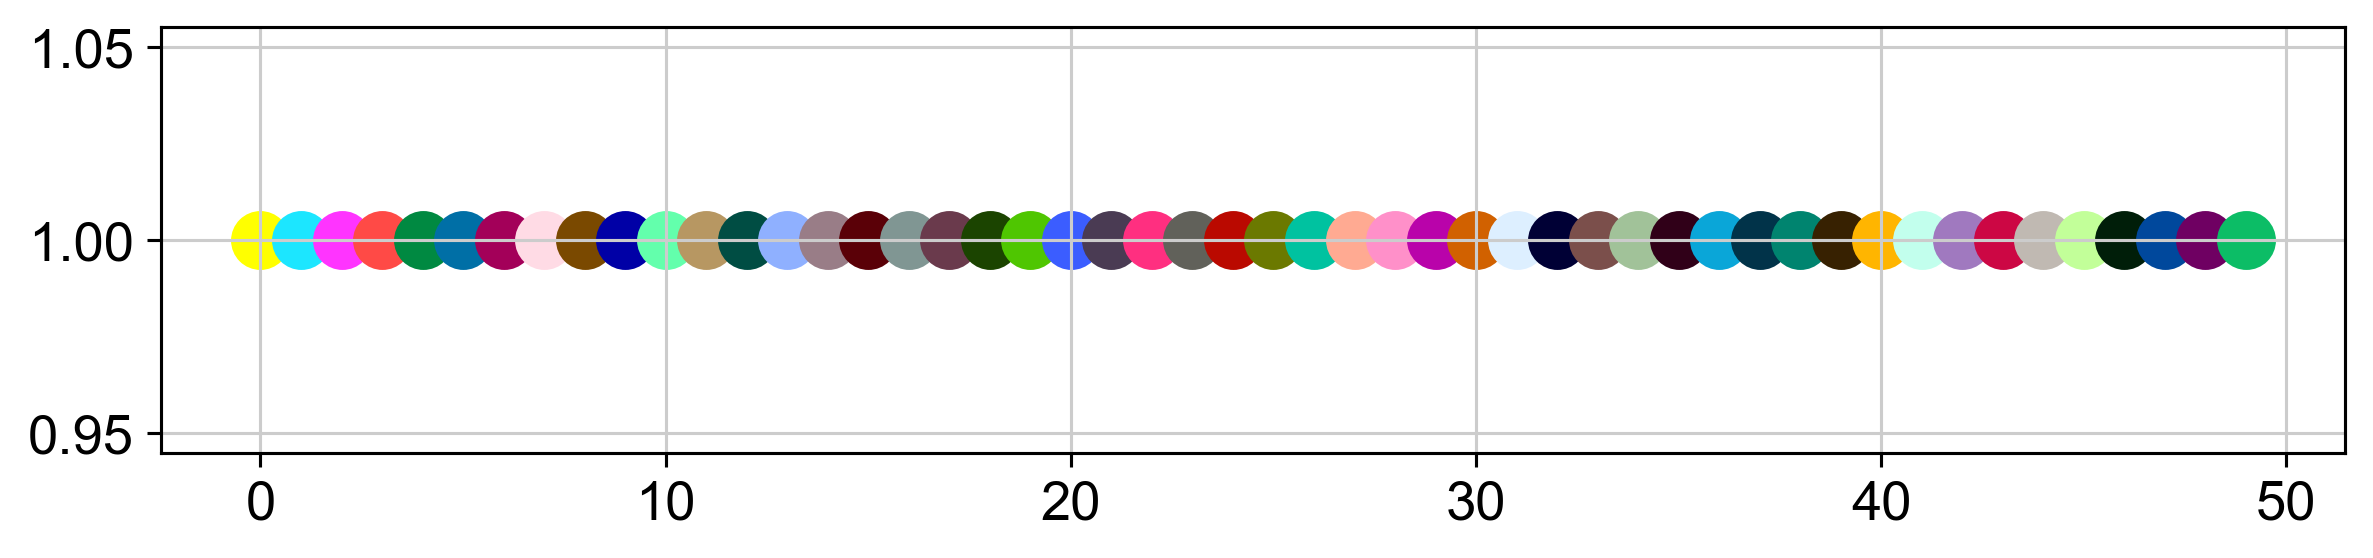

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
pl.figure(figsize=(10, 2))
for i in range(50):
    pl.scatter(i, 1, c=sc.pl.palettes.godsnot_102[i], s=200)
pl.show()

In [73]:
default_colors = np.array(sc.pl.palettes.godsnot_102)
new_colors = np.array(adata_subset.uns['leiden_colors'])

In [74]:
new_colors[[0]] = default_colors[[44]]  # 'LWC14dpwPNeg'
new_colors[[1]] = default_colors[[36]]  #  'LWC14dpwPos'
new_colors[[2]] = default_colors[[20]]  #  'LWC14dpwPos'
new_colors[[3]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[4]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[5]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[6]] = default_colors[[9]]  #  'LWC14dpwPos'
new_colors[[7]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[8]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[9]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[10]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[11]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[12]] = default_colors[[44]]  #  'LWC14dpwPos'
new_colors[[13]] = default_colors[[44]]  #  'LWC14dpwPos'


In [75]:
#new_colors[[0]] = default_colors[[8]]  # 'LWC14dpwPNeg'
#new_colors[[1]] = default_colors[[47]]  #  'LWC14dpwPos'
#new_colors[[2]] = default_colors[[47]]  #  'LWC14dpwPos'
#new_colors[[3]] = default_colors[[40]]  #  'LWC14dpwPos'
#new_colors[[4]] = default_colors[[40]]  #  'LWC14dpwPos'
#new_colors[[5]] = default_colors[[8]]  #  'LWC14dpwPos'
#new_colors[[6]] = default_colors[[40]]  #  'LWC14dpwPos'
#new_colors[[7]] = default_colors[[8]]  #  'LWC14dpwPos'
#new_colors[[8]] = default_colors[[47]]  #  'LWC14dpwPos'
#new_colors[[9]] = default_colors[[8]]  #  'LWC14dpwPos'
#new_colors[[10]] = default_colors[[6]]  #  'LWC14dpwPos'
#new_colors[[11]] = default_colors[[6]]  #  'LWC14dpwPos'
#new_colors[[12]] = default_colors[[47]]  #  'LWC14dpwPos'
#new_colors[[13]] = default_colors[[47]]  #  'LWC14dpwPos'


In [76]:
adata_subset.uns['leiden_colors'] = new_colors

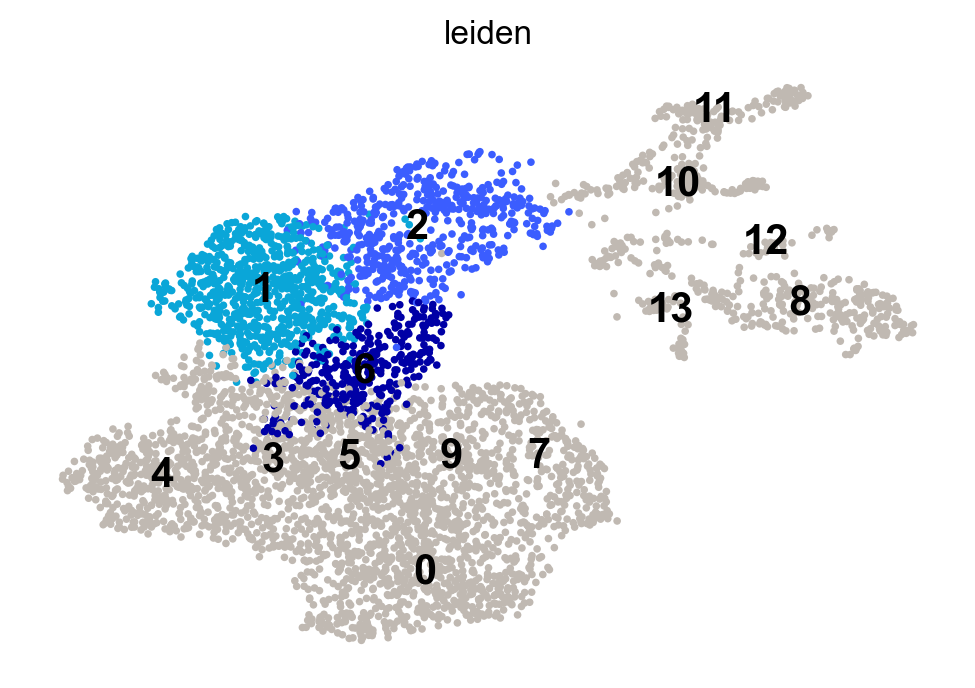

In [87]:
sc.pl.umap(adata_subset, color='leiden', legend_loc='on data', legend_fontsize='15.0',
           frameon=False, size=30)

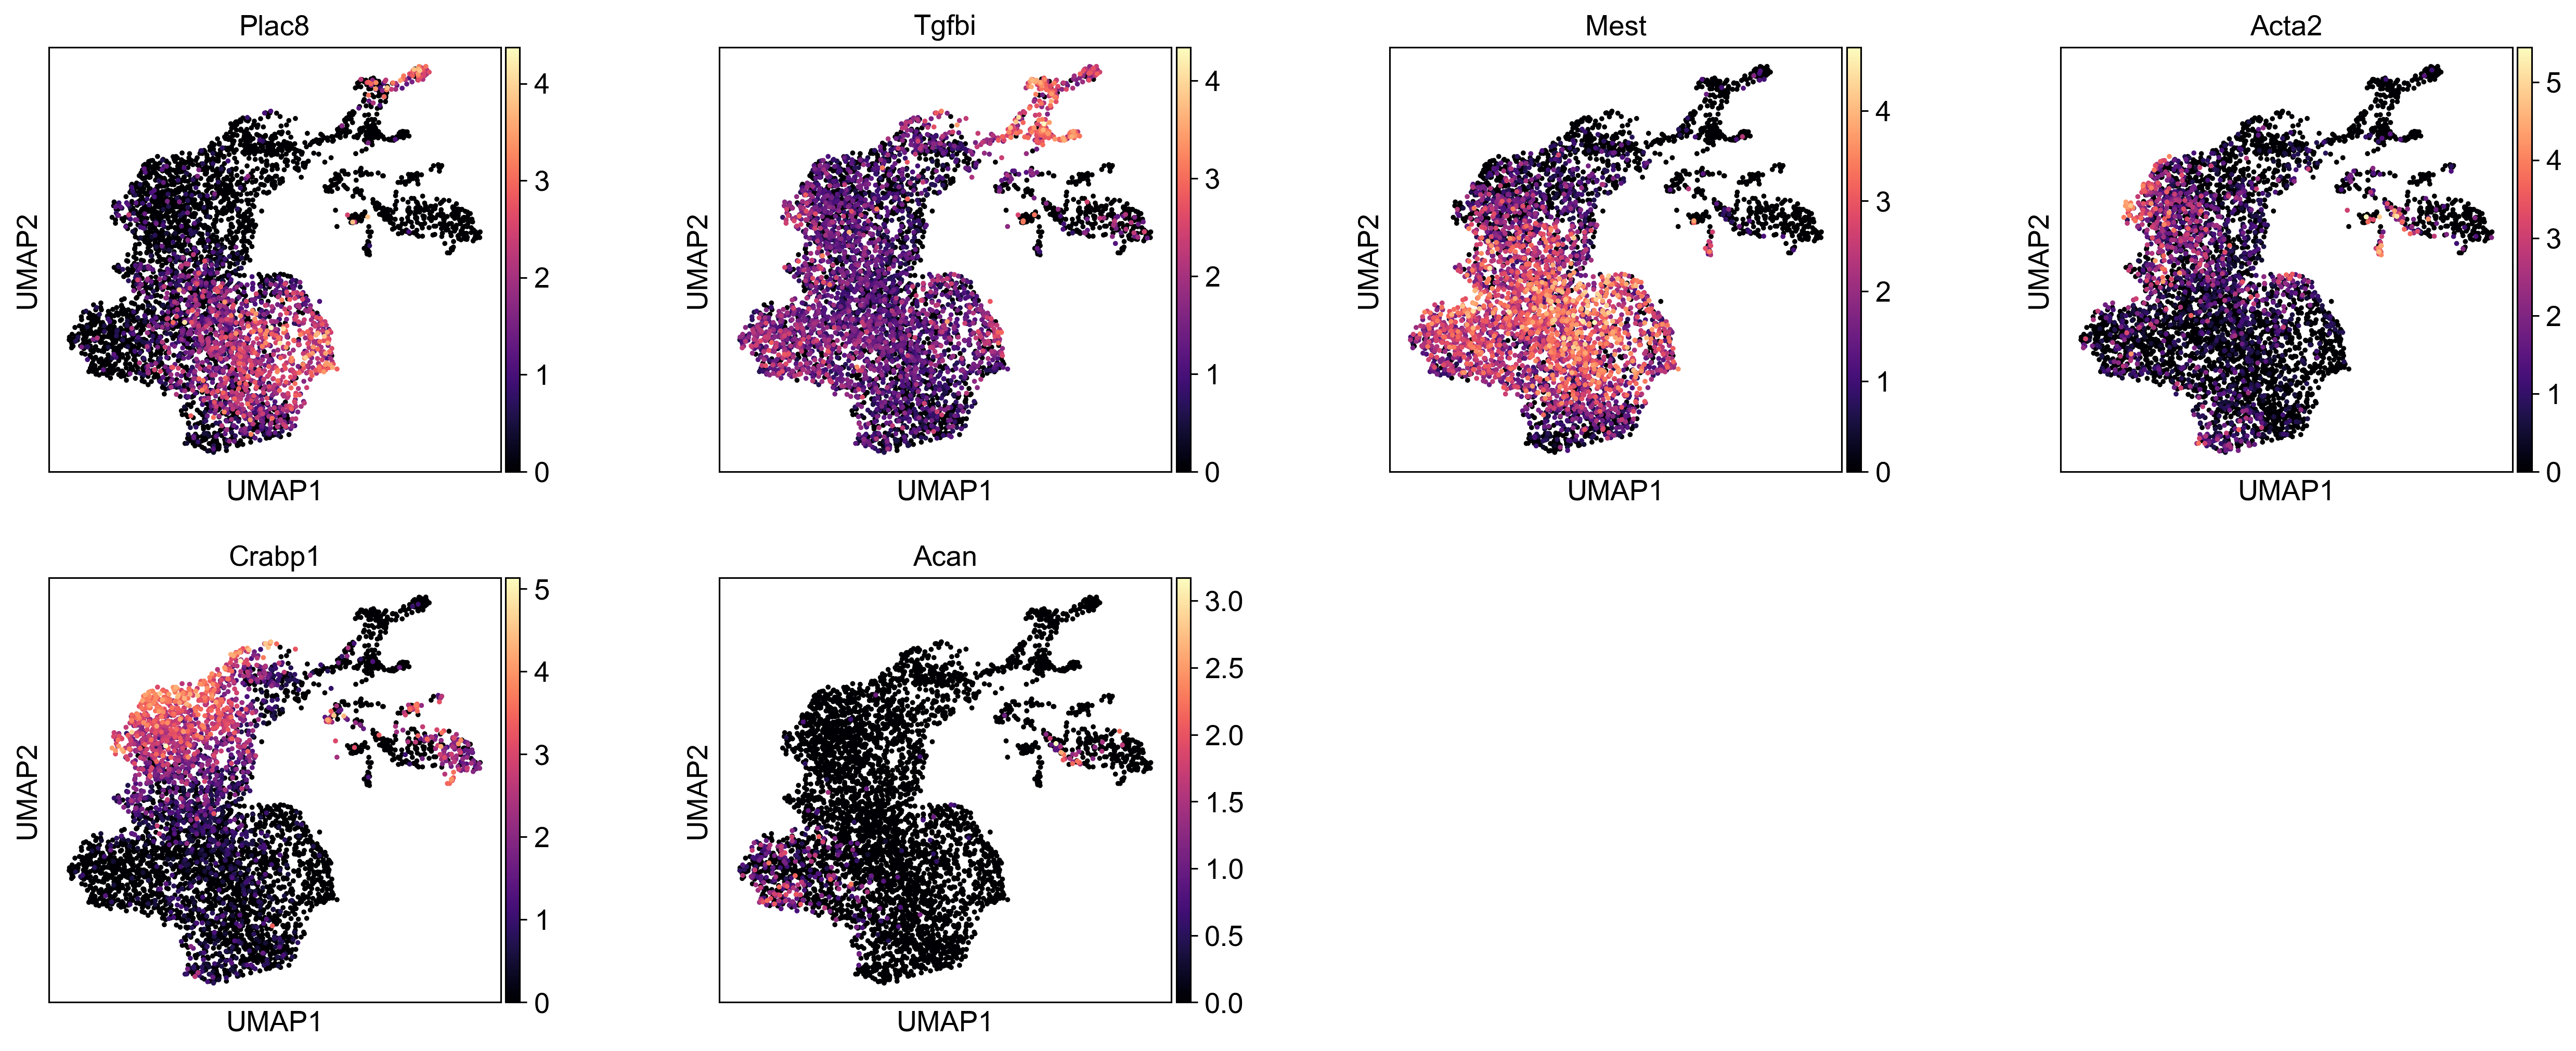

In [72]:
sc.pl.umap(adata_subset, color=['Plac8','Tgfbi',
                               'Mest','Acta2',
                                'Crabp1','Acan'], 
           color_map= 'magma',
           wspace=0.35)

In [79]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.1 (python 3.7.6) on 2020-10-17 12:37.
 Your version: 		 0.2.1 
 Latest version: 	 0.2.2


In [80]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [81]:
adata_subset

AnnData object with n_obs × n_vars = 4798 × 2806
    obs: 'batch', 'Time', 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Time_colors', 'batch_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

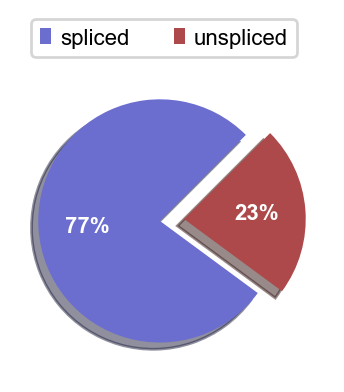

In [82]:
scv.pl.proportions(adata_subset)

In [83]:
scv.pp.filter_and_normalize(adata_subset)
scv.pp.moments(adata_subset)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [84]:
scv.tl.velocity(adata_subset)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [85]:
scv.tl.velocity_graph(adata_subset)

computing velocity graph
    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


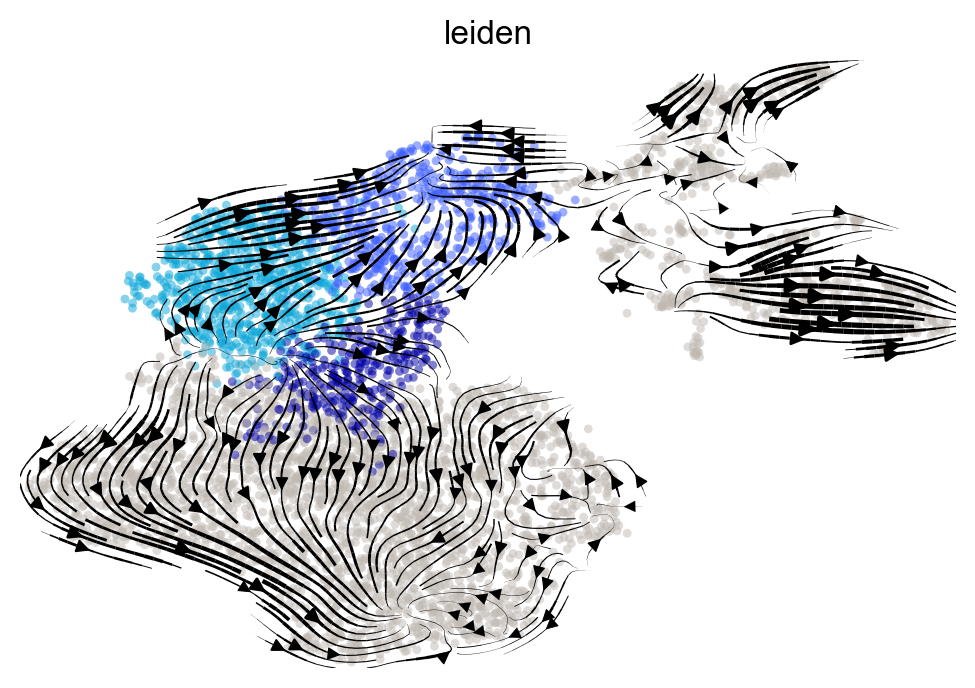

In [86]:
scv.pl.velocity_embedding_stream(adata_subset, basis='umap', color='leiden',
                                legend_loc='none', alpha=0.5, size=40,
                                density=1.5)

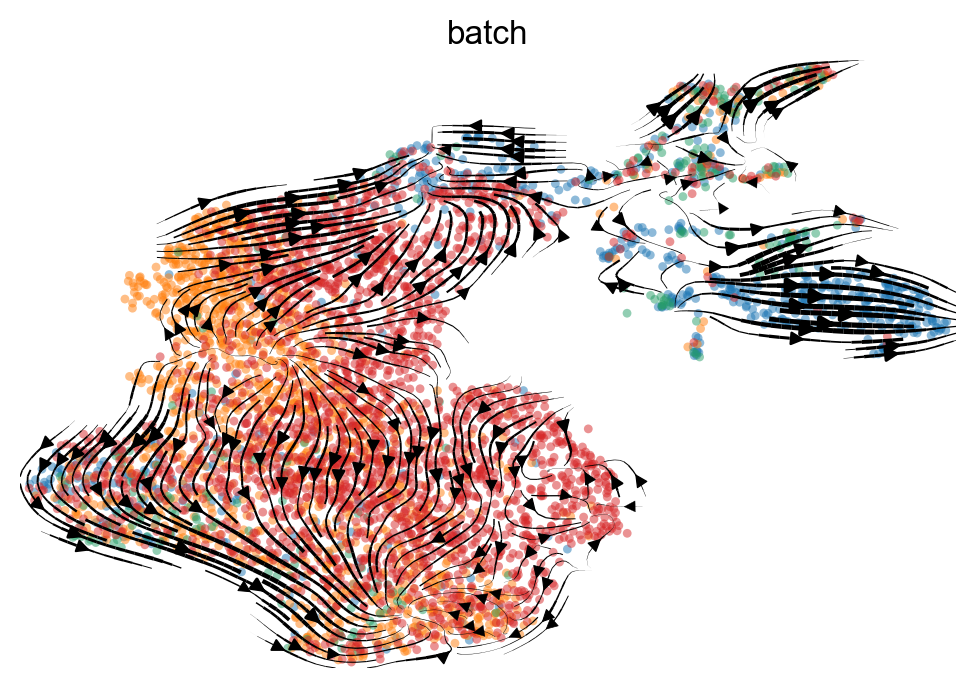

In [81]:
scv.pl.velocity_embedding_stream(adata_subset, basis='umap', color='batch',
                                legend_loc='none', alpha=0.5, size=40,
                                density=1.5)

In [83]:
scv.tl.rank_velocity_genes(adata_subset, groupby='leiden', min_corr=.3, n_genes=10000)

df = scv.DataFrame(adata_subset.uns['rank_velocity_genes']['names'])
df.head(1000)

ranking velocity genes
    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


0        1         2        3         4        5        6        7  \
0     Tshz2   Glipr1     Prex1   Col5a3       Bgn    Abcc9     Fbn2    Tshz2   
1       Zyx    Mmp11     Vamp5  Gm16685    Tm4sf1  Col12a1    Abcc9    Scn7a   
2    Lsmem1    Dock5    Zfp536     Meg3      Meg3     Fbn2     Gpc3    Sfrp4   
3    Ifi207   Sbspon     Dock5   Lgals3    Mpped2     Gpc3  Angptl1    Parm1   
4    Cyp1b1  Bcl2l11    Rassf3   Il1rl1    Plagl1   Tm4sf1      Clu    Fxyd1   
..      ...      ...       ...      ...       ...      ...      ...      ...   
261   Prex1    Dapk1     Il6ra     Gpc3     Rspo3    Dock5    Trps1   Hs3st1   
262   Prdm1    Fxyd1  Serping1   Cthrc1    Thsd7a   Rassf3     Fgd5  Bcl2l11   
263  Rassf3   Lsmem1     Tshz2      Ptn     Ltbp1   Thsd7a     Zeb2    Ltbp1   
264   Dock5     Esr1    Lgals3  Col12a1  Serping1    Ltbp1    Tshz2    Prdm1   
265   Vamp5    Tshz2      Meg3     Fbn2      Zeb2     Zeb2    Smoc2     Dlk1   

           8         9       10       11       12        13  
0    Col11a1     Ptch2     Fgd5     Esr1    Lamc3  Serping1  
1      Prex2   Col18a1       Ar   Thsd7a     Bcl2    Plscr4  
2       Nav2    Sorbs2    Icam1    Gfpt2     Nav2      Tle4  
3      Trps1  Serping1   Zbtb16    Tshz2    Spon1   Ifi202b  
4    Col23a1     Scn7a    Prex1   Zbtb16   Rassf3     Lockd  
..       ...       ...      ...      ...      ...       ...  
261      Zyx      Mylk  Col15a1     Hpgd   Krtdap      Ugdh  
262      Maf     Prex1    Inhba    Gcnt2    Hmox1       Emb  
263     Atf3     Ltbp1      Eln      Bgn      Mt1     Timp1  
264      Bgn    Tnfsf8  Col27a1     Gpc3  Cyp26b1      Meg3  
265     Meg3     Mfap5     Meg3  Col27a1     Meg3     Hmox1  

[266 rows x 14 columns]